In [3]:
from tools import analysistools as atools
import nanoparticle
from nanoparticle import Ligand, NanoParticle
import math
from membranesimulation import MembraneSimulation
import numpy as np
from tools import icosatiler
from tools import vectools
from tools import misctools
import k3d
import os
import random
import pickle
from numpy import pi, cos, sin, arccos, arange
import networkx as nx

In [4]:
mag = lambda v : np.sqrt(np.sum([i*i for i in v]))

In [5]:
def goldenSpiral(n,rad):
    num_pts = 60
    indices = arange(0, n, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/n)
    theta = pi * (1 + 5**0.5) * indices
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    sphs = []
    for i in range(len(x)):
        spp = icosatiler.crt2SphPol((x[i],y[i],z[i]))
        spp = (rad,spp[1],spp[2])
        sphs.append(spp)
    return sphs
    

In [6]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [7]:
def norm(v):
    m = mag(v)
    vN = [float(i)/float(m) for i in v]
    return vN

In [8]:
def crossProd(u,v):
    return ((u[1]*v[2]-u[2]*v[1]),(u[2]*v[0]-u[0]*v[2]),(u[0]*v[1]-u[1]*v[0]))

In [9]:
def makeParticleModelFromPhenome(particle):
    points = []
    plot = k3d.plot()
    i = 1
    maxEps = 0
    for l in particle.ligands:
        if l.eps>maxEps:
            maxEps = l.eps
    for l in particle.ligands:
        if l.eps > 0.0:
            lx = l.rad*np.sin(l.polAng)*np.cos(l.aziAng)
            ly = l.rad*np.sin(l.polAng)*np.sin(l.aziAng)
            lz = l.rad*np.cos(l.polAng)
            lc = '0x' + ('#%02x%02x%02x' % (0, int((l.eps/maxEps)*255.0), 0))[1:]
            
            plot += k3d.points([lx,ly,lz],point_size=1,color=int(lc, 16))
            #plot += k3d.points([lx,ly,lz],point_size=1,color=int(0x00ffff*(l.eps/maxEps)))
            plot += k3d.text(str(i),[lx,ly,lz],color=0xffffff)
            i+=1
    plot += k3d.points([0,0,0],point_size=7,color=0xff0000)
    return plot

In [10]:
def buildCoveredParticle(eps,rad):
    particle = NanoParticle()
    lPos = icosatiler.cover72SpherePolar(rad)
    for v in lPos:
        particle.addLigand(Ligand(eps,1,v[0],v[1],v[2]))
    return particle

In [11]:
def spaceIsOccupied(particle,v):
    for l in particle.ligands:
        d = atools.greatArcDist((l.polAng,l.aziAng),(v[1],v[2]),particle.sig)
        if abs(d) < l.size:
            return True
    return False

In [12]:
def getClosestIcos(particle,v):
    lPos = icosatiler.cover72SpherePolar(particle.sig)
    closest = v
    minD = 1e8
    for l in lPos:
        v1 = icosatiler.sphPol2Crt(l) 
        v2 = icosatiler.sphPol2Crt(v)
        d = np.sum([j*j for j in np.subtract(v1,v2)])
        if abs(d) < minD:
            minD = d
            closest = l
    return closest

In [13]:
# lPos = icosatiler.cover72SpherePolar(4)
# dists = []
# minD = 1e8
# for v in lPos:
#     for l in lPos:
#         if l != v:
#             v1 = icosatiler.sphPol2Crt(l) 
#             v2 = icosatiler.sphPol2Crt(v)
#             d = np.sum([j*j for j in np.subtract(v1,v2)])
#             if abs(d) < minD:
#                 minD = d
#     dists.append(np.sqrt(minD))
# print np.mean(dists)

In [14]:
def addLigand(particle,eps,v,lock=False):
    if lock:
        v = getClosestIcos(particle,v)
    if not spaceIsOccupied(particle,v):
        particle.addLigand(Ligand(eps,1,v[0],v[1],v[2]))
    return particle

In [15]:
def addBelt(particle,eps,rad,n,phi,lock=False):
    step = np.pi*2/float(n)
    for i in range(n):
        v = (rad,step*i,phi)
        particle = addLigand(particle,eps,v,lock)
    return particle

In [16]:
def getArcAngle(dist,rad):
    return dist/rad

In [17]:
def addRing(particle,eps,rad,pos,n,spacing,lock=False):
    step = np.pi*2/float(n)
    if lock:
        origin = getClosestIcos(particle,(rad,pos[0],pos[1]))
        pos = (origin[1],origin[2])
    for i in range(n):
        tD = getArcAngle(spacing,rad)
        tP = step*i
        v = (rad,tD,tP)
        vC = icosatiler.sphPol2Crt(v)
        v1 = icosatiler.sphPol2Crt((rad,0,0))
        v2 = icosatiler.sphPol2Crt((rad,pos[0],pos[1]))
        v3 = crossProd(v1,v2)
        if np.sum([j*j for j in v3])== 0.0:
            #it's parallel!
            particle = addLigand(particle,eps,v,lock)
            continue
        dp = np.dot(v1,v2)
        #the magic sauce :)
        ang = np.arctan2(mag(np.cross(v1,v2)), np.dot(v1,v2))
        rM = vectools.buildERMatrix(v3, ang)
        vC = np.dot(rM,vC)
        v = icosatiler.crt2SphPol(vC)
        particle = addLigand(particle,eps,v,lock)
    return particle

In [18]:
def addPatch(particle,eps,rad,pos,n,spacing,lock=False):
    if lock:
        origin = getClosestIcos(particle,(rad,pos[0],pos[1]))
        pos = (origin[1],origin[2])
    particle = addLigand(particle,eps,(rad,pos[0],pos[1]),lock)
    particle = addRing(particle,eps,rad,pos,n,spacing,lock)
    return particle

In [19]:
def addMesh(particle,eps,rad,n,lock=False):
    mesh = goldenSpiral(n,particle.sig)
    for point in mesh:
        particle = addLigand(particle,eps,point,lock)
    return particle

In [20]:
#makeParticleModelFromPhenome(buildCoveredParticle(6,4))

In [185]:
zoo = {}
minEps = 160
maxEps = 360
epsStep = 10
minNum = 12
maxNum = 60
numStep = 6

In [186]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for i in xrange(minNum,maxNum,numStep):
        p = NanoParticle()
        p = addMesh(p,1,4,i,False)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["sp_"+str(len(p.ligands))+"_"+str(totalEps)] = p

In [187]:
sp = 1.5
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/6.0),int(maxNum/6.0),int(numStep/6.0)):
        p = NanoParticle()
        for i in range(4):
            p = addPatch(p,1,4,(float(i)*(np.pi*0.5),0),n,sp)
        for i in range(2):
            p = addPatch(p,1,4,((np.pi*0.5),float(i)*(np.pi)+0.5*np.pi),n,sp)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["cube_"+str(len(p.ligands))+"_"+str(totalEps)] = p

In [188]:
sp = 2.5
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in range(int(minNum/6.0),int(maxNum/6.0),int(numStep/6.0)):
        p = NanoParticle()
        for i in range(4):
            p = addRing(p,1,4,(float(i)*(np.pi*0.5),0),n,sp)
        for i in range(2):
            p = addRing(p,1,4,((np.pi*0.5),float(i)*(np.pi)+0.5*np.pi),n,sp)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["ring_"+str(len(p.ligands))+"_"+str(totalEps)] = p

In [189]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/2.0+2.0),int(maxNum/2.0+2.0),int(numStep/2.0)):
        p = NanoParticle()
        p = addBelt(p,1,4,n,0)
        p = addBelt(p,1,4,n,np.pi*0.5)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["cross_"+str(len(p.ligands))+"_"+str(totalEps)] = p

In [190]:
for totalEps in xrange(minEps,maxEps,epsStep):
    for n in xrange(int(minNum/3.0),int(maxNum/3.0),4):
        p = NanoParticle()
        p = addBelt(p,1,4,n,0)
        p = addBelt(p,1,4,n,np.pi*0.5)
        p = addRing(p,1,4,(0,0),n,np.pi*2)
        eps = float(totalEps)/(float(len(p.ligands)))
        for l in p.ligands:
            l.eps = eps
        zoo["octet_"+str(len(p.ligands))+"_"+str(totalEps)] = p

In [191]:
makeParticleModelFromPhenome(p)

Plot(antialias=True, background_color=16777215, grid=[-1, -1, -1, 1, 1, 1], height=512, object_ids=[120987133264, 120983029456, 120989702544, 120987135568, 120987135056, 120987132624, 120987134928, 120987134736, 120987134608, 120987132432, 120987133712, 120987135952, 120987134416, 120987134672, 120987134352, 120987135248, 120987177424, 120991158096, 120982926736, 120987178128, 120987179472, 120987135632, 120987178064, 120987180240, 120982929168, 120987177808, 120987180112, 120987178832, 120987178320, 120987179088, 120987179664, 120987177488, 120987177104, 120987177040, 120989656080, 120987179408, 120984295760, 120987180368, 120989923856, 120989924432, 120984387472, 120987179536, 120984384784, 120987178448, 120984295888, 120984387408, 120987180432, 120984385104, 120984385424, 120984385744, 120984384080, 120984384656, 120984386576, 120984386512, 120987179984, 120984384592, 120984385936, 120984386064, 120984386448, 120984383568, 120984386384, 120984385168, 120984384144, 120984386256, 120984385808, 120985358288, 120984386128, 120985356176, 120985354384, 120985357904, 120985356560, 120984384400, 120985357136, 120985357584, 120985355344, 120985358160, 120985356368, 120985356816, 120985355024, 120985357840, 120985356496, 120985357328, 120969723664, 120985357648, 120987132240])

In [192]:
for k, v in zoo.iteritems():
    print k

sp_12_250
cube_24_330
cross_43_270
sp_18_230
ring_12_180
sp_18_330
cross_33_240
ring_48_240
octet_18_260
cross_21_260
cube_36_250
ring_24_190
octet_30_190
sp_42_350
cube_36_310
ring_54_220
ring_12_170
sp_30_230
cross_14_330
cross_25_270
cross_38_260
octet_30_260
sp_54_280
cube_24_200
cube_54_300
sp_48_270
cross_43_310
sp_30_190
sp_18_240
octet_18_160
cube_48_330
sp_42_210
cube_60_280
cube_42_170
cube_48_230
sp_42_190
cross_25_180
cube_18_340
cube_36_220
cross_26_170
ring_12_350
ring_54_310
cube_18_290
ring_12_210
sp_30_280
cube_18_350
sp_42_270
sp_42_170
cross_21_170
cube_54_230
cube_18_170
cube_18_270
cube_36_160
sp_36_210
sp_24_290
cross_26_280
sp_42_280
cube_60_230
ring_42_170
sp_30_340
cross_43_180
cube_18_180
ring_12_320
octet_30_310
octet_42_250
ring_42_290
sp_42_300
sp_30_240
cube_30_230
sp_54_230
cube_30_330
ring_42_190
sp_54_330
octet_6_240
ring_18_200
ring_54_340
ring_36_260
ring_30_160
ring_18_160
sp_24_200
sp_48_180
cross_26_210
cross_33_280
cube_24_270
octet_18_220
cross_3

In [193]:
with open('zoo.pickle', 'wb') as handle:
    pickle.dump(zoo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Networks

In [197]:
nets = []
for k, v in zoo.iteritems():
    nets.append((k,atools.pruneNetwork(atools.buildLigandNetwork(v.ligands),0.5)))
    

In [213]:
netFilePath = 'db/zoo-nets.csv'

with open(netFilePath, 'w') as netFile:

    netWriter = atools.UnicodeWriter(netFile)

    netWriter.writerows([[
            "Name",
            "Density",
            "Max Diameter",
            "Mean Diameter",
            "Min Radius",
            "Average Radius",
            "Subgraph Number",
            "Estrada Coefficient"
            ]])

    for n in nets:
        pN = n[1]
        density = nx.density(pN)
        graphs = list(nx.connected_component_subgraphs(pN))
        dS = []
        rS = []
        for g in graphs:
            d = nx.diameter(g)
            r = nx.radius(g)
            dS.append(d)
            rS.append(r)
        maxDiameter = np.max(dS)
        avgDiameter = np.mean(dS)
        minRadius = np.min(rS)
        avgRadius = np.mean(rS)
        subgraphs = len(graphs)
        estrada = nx.estrada_index(pN)

        netWriter.writerows([[
            str(n[0]),
            str(density),
            str(maxDiameter),
            str(avgDiameter),
            str(minRadius),
            str(avgRadius),
            str(subgraphs),
            str(estrada)
        ]])

# Analysis

In [20]:
import csv

In [21]:
def makeHeatmap(array,label,annot=False):
    df = pd.DataFrame.from_dict(np.array(array).T)
    df.columns = ['Affinity (kT)','Ligand Number',label]
    df['Z_value'] = pd.to_numeric(df[label])
    pf = df.pivot('Ligand Number','Affinity (kT)',label)
    return sns.heatmap(pf, cmap="cool",annot=False, fmt='.1f')

In [25]:
typeData = {}

with open('/Users/joel/Downloads/zoo.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        rowsplit = ', '.join(row).split(',')
        ftype = rowsplit[0].split('_')
        ptype = ftype[0]
        nlig = int(ftype[1])
        teps = int(ftype[2])
        if not ptype in typeData:
            typeData[ptype] = {}
        if not nlig in typeData[ptype]:
            typeData[ptype][nlig] = {}
        if not teps in typeData[ptype][nlig]:
            typeData[ptype][nlig][teps] = [float(i) for i in rowsplit[1:]]

fitnesses = {}
budtimes = {}
ptypes = []

for t,v in typeData.iteritems():
    ptypes.append(t)
    if not t in fitnesses:
        fitnesses[t] = []
    if not t in budtimes:
        budtimes[t] = []           
    for nl,v in typeData[t].iteritems():
        for eps,v2 in v.iteritems():
            fitnesses[t].append([nl,eps,v2[2]])
            budtimes[t].append([nl,eps,v2[4]])
        

In [23]:
def splitToXYZ(array):
    x = np.array(array)[:, 0]
    y = np.array(array)[:, 1]
    z = np.array(array)[:, 2]
    return [x,y,z]

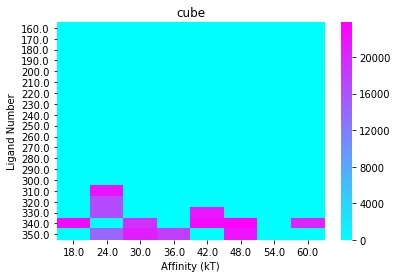

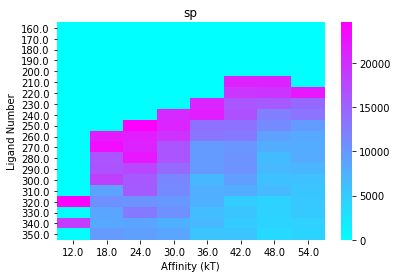

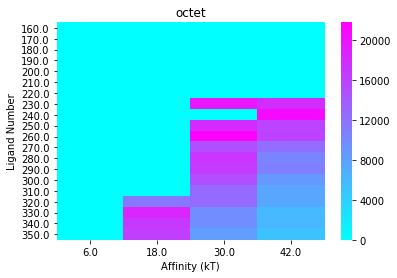

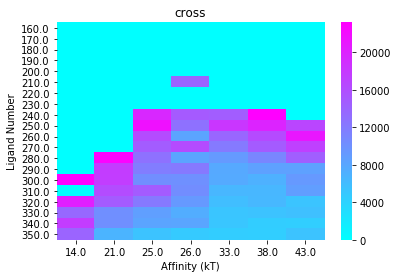

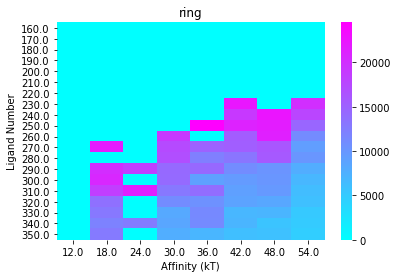

In [27]:
import pandas as pd
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns

for t in ptypes:
    makeHeatmap(splitToXYZ(budtimes[t]),"Ring Budtimes",annot=True)
    plt.title(t)
    plt.show()